In [27]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('src'), '..')))

import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr
from src.DataLoader import TableDatasetPath, TableDatasetDF
from functools import partial
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from src.tools import *
from src.trainer import Trainer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
BATCH_SIZE = 5000
NUM_FEATURES = 15

In [16]:
df = pd.read_csv('../data/data_fe.csv')

feature_importance = pd.read_csv('../data/feature_imporstance_WS.csv')

features = list(feature_importance.iloc[:NUM_FEATURES]['feature_names'])
df = df[features + ['Machine failure']]

df_train, df_test = train_test_split(df,
                                     shuffle=True,
                                     stratify=df['Machine failure'])
# df_train = upsampling(df_train)

In [17]:
train_dataset = TableDatasetDF(df_train)
val_dataset = TableDatasetDF(df_test)

In [18]:
# train_dataset, val_dataset = balance_val_split(dataset)

In [19]:
# class_counts = np.bincount(df['Machine failure'])
# weights = 1.0 / class_counts
# sample_weights = weights[df['Machine failure']]

# # Define sampler with weighted sampling
# sampler = data.WeightedRandomSampler(sample_weights, len(sample_weights))

In [20]:
train_dl = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_dl = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True
)

In [21]:
model = nn.Sequential(
    nn.Linear(NUM_FEATURES, 500),
    nn.ReLU(),
    nn.Linear(500, 1000),
    nn.ReLU(),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.Linear(400, 300),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 2)
)

In [22]:
model = nn.Sequential(
    nn.Linear(NUM_FEATURES, 256),
    nn.BatchNorm1d(256),
    nn.Dropout(0.3),
    nn.LeakyReLU(0.1),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.Dropout(0.3),
    nn.PReLU(),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.Dropout(0.3),
    nn.GELU(),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.Dropout(0.3),
    nn.ELU(),
    nn.Linear(16, 2)
)


In [23]:
weights_classes = compute_class_weight('balanced',classes = np.unique(df_test['Machine failure']) , y = df_test['Machine failure'])

In [28]:
class Loss_class:
    def __init__(self,loss):
        self.loss = loss
        
    def __call__(self, y_pred, y_true):
      out = self.loss(y_pred, y_true)
      y_pred = torch.softmax(y_pred, dim=1)
      accuracy = (y_pred.argmax(dim=1) == y_true).float().mean()
      f1_sc = f1_score(y_true.cpu(), y_pred.argmax(dim=1).cpu(), average='macro')
      y_pred = y_pred.detach().cpu().numpy()
      y_true = y_true.cpu().numpy()
      fpr, tpr, _ = metrics.roc_curve(y_true, y_pred[:, 1])
    #   plt.scatter(fpr, tpr)
    #   plt.show()
      auc_score = metrics.auc(fpr, tpr)
      return out, {'loss': out.item(), 'accuracy': accuracy.item(), 'f1_score': f1_sc, 'auc_score': auc_score}


In [29]:
loss = Loss_class(nn.CrossEntropyLoss(weight=torch.FloatTensor(weights_classes)))
model_factory = partial(Model_class)
optimizer_factory = partial(torch.optim.AdamW)
scheduler_factory = partial(lr.ExponentialLR)

model_params = dict(model=model,
                    device=device)
optimizer_params = dict(weight_decay=1e-3, lr=1e-2)
scheduler_params = dict(gamma=0.9)

learning_params = dict(batch_size=BATCH_SIZE, num_epoch=30)

wandb_init_params = dict(
    name='data_fe_lr_1e-3',
    project="Internship_project"
)

In [30]:
trainer = Trainer(train_dl,
                  val_dl,
                  loss,
                  model_factory=model_factory,
                  optimizer_factory=optimizer_factory,
                  scheduler_factory=scheduler_factory,
                  model_params=model_params,
                  optimizer_params=optimizer_params,
                  scheduler_params=scheduler_params,
                  log=True,
                  wandb_init_params=wandb_init_params
                  )

I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

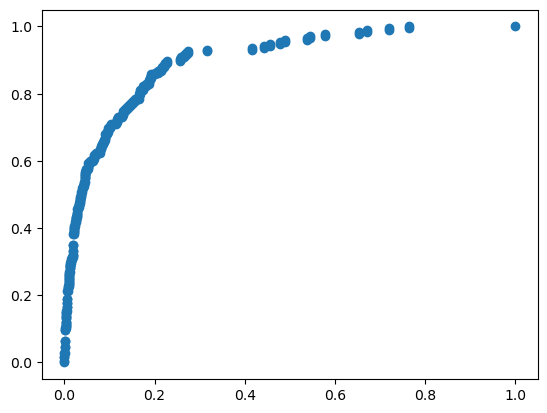

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.74s/it]

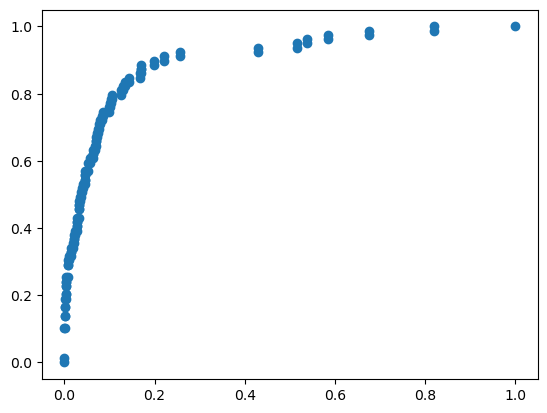

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

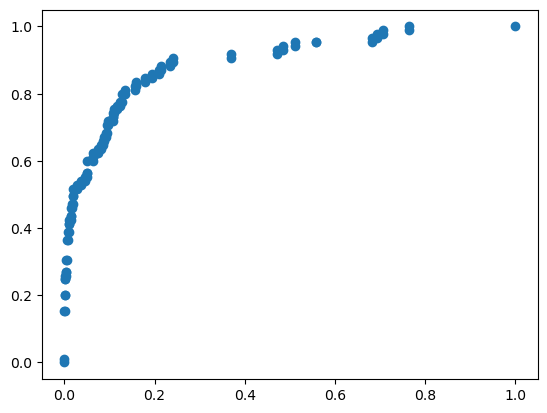

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Epoch: 1 of 30, 0.066 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

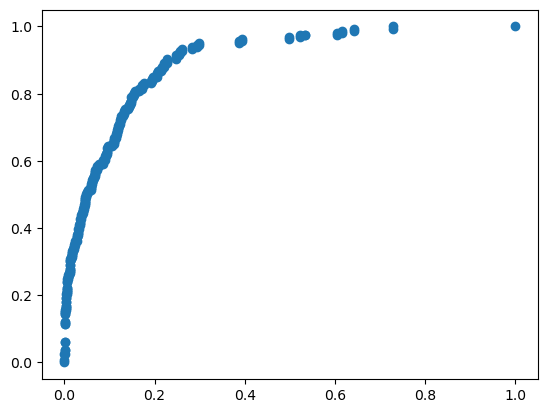

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.72s/it]

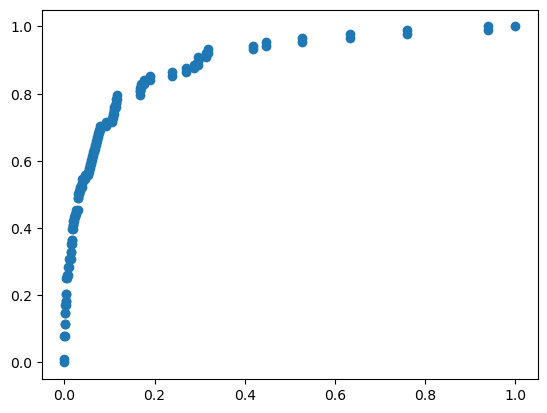

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

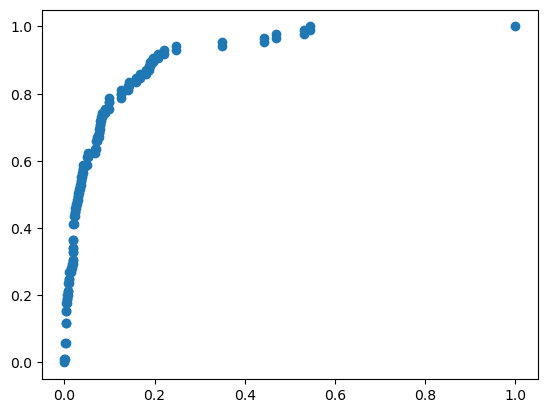

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Epoch: 2 of 30, 0.064 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

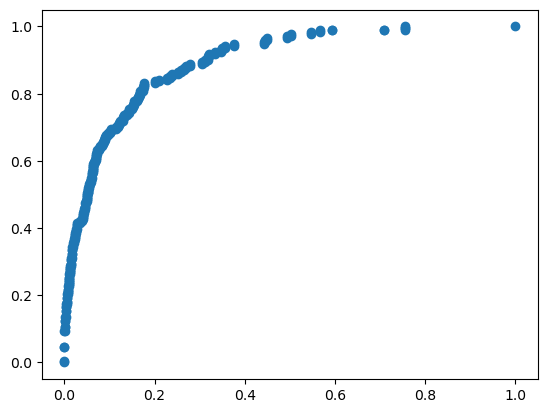

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.89s/it]

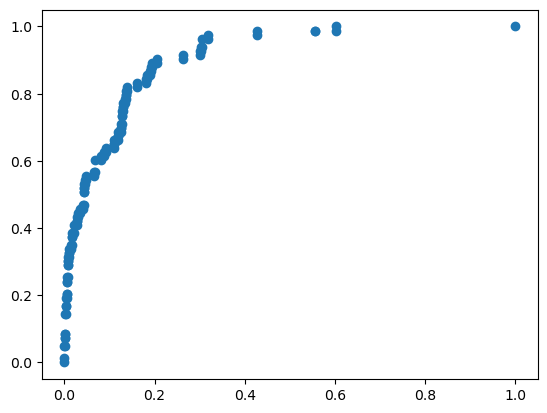

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

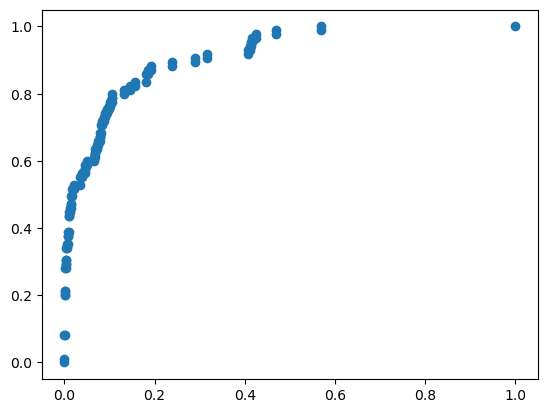

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Epoch: 3 of 30, 0.063 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

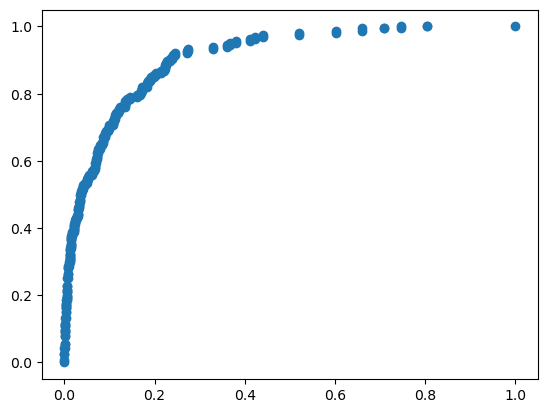

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.50s/it]

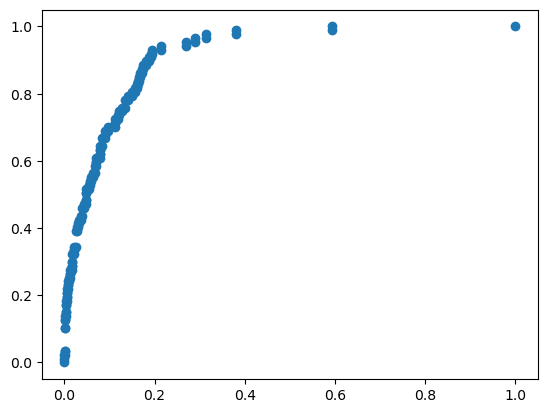

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

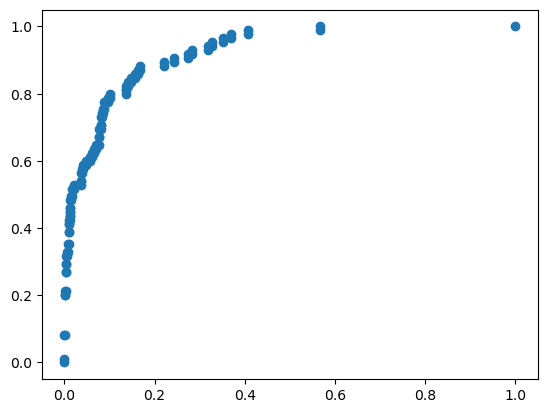

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Epoch: 4 of 30, 0.057 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

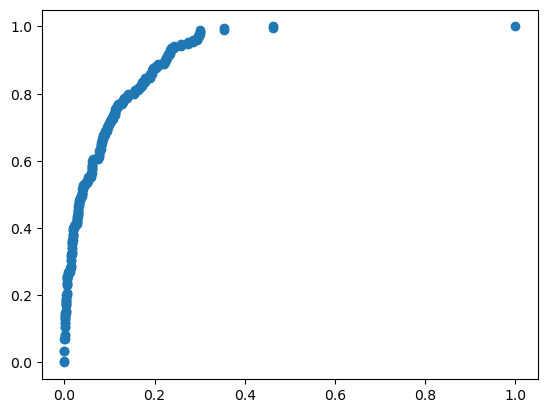

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.55s/it]

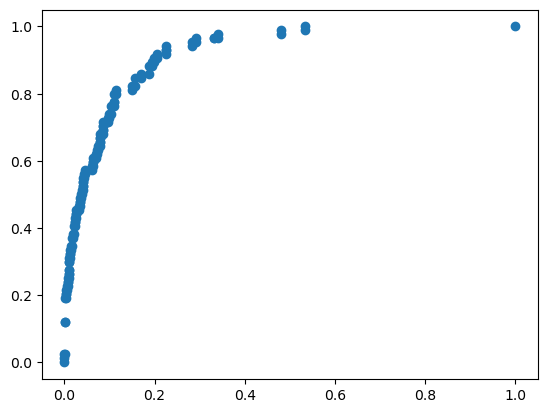

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

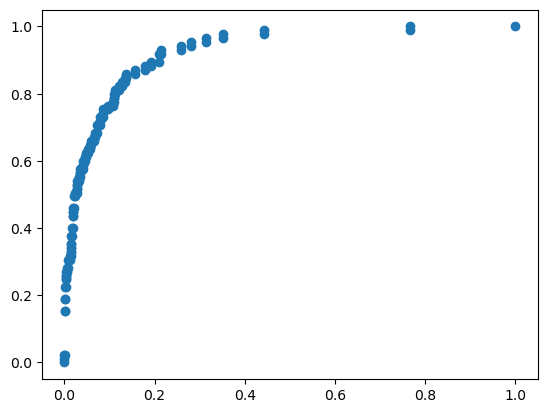

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


Epoch: 5 of 30, 0.057 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

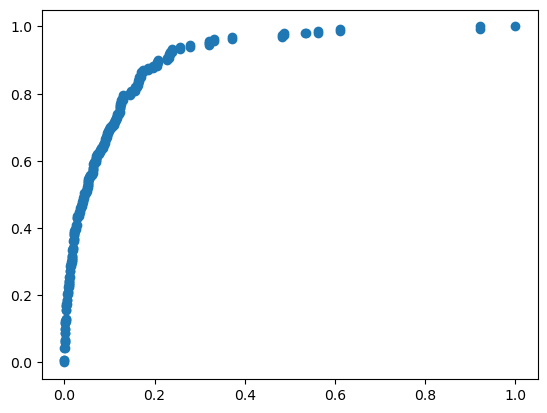

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.63s/it]

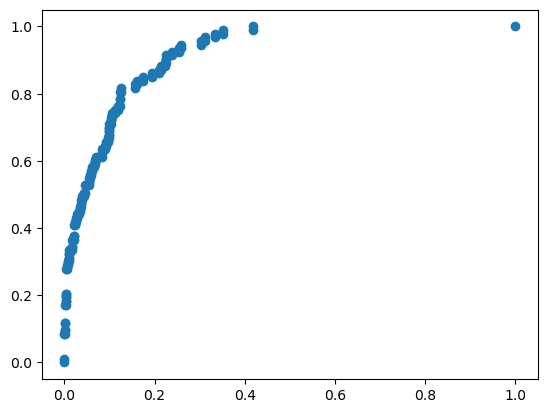

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

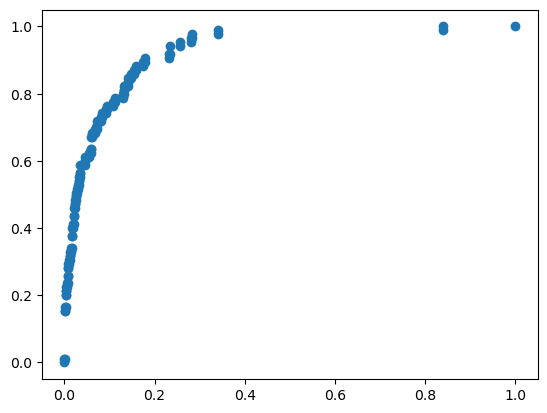

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Epoch: 6 of 30, 0.059 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

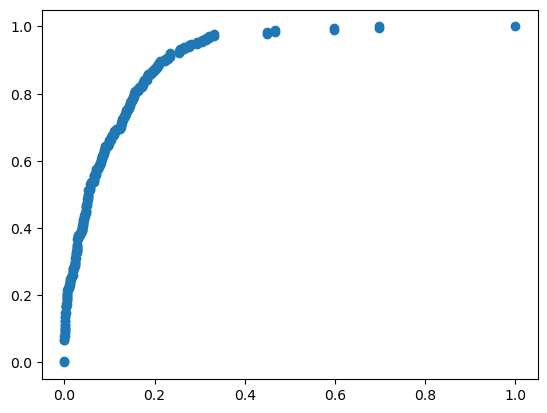

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.78s/it]

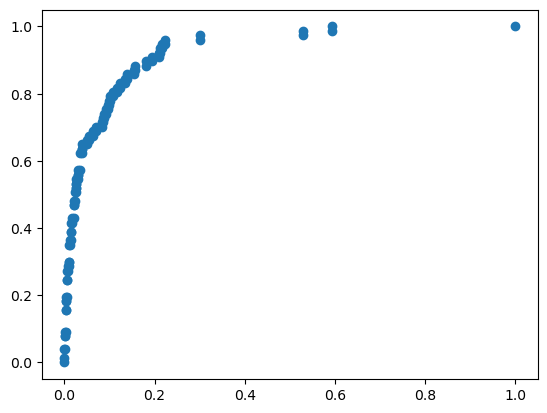

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

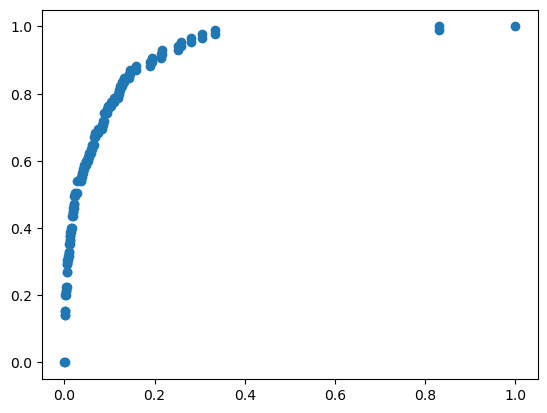

Let's see how good I am...: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Epoch: 7 of 30, 0.067 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

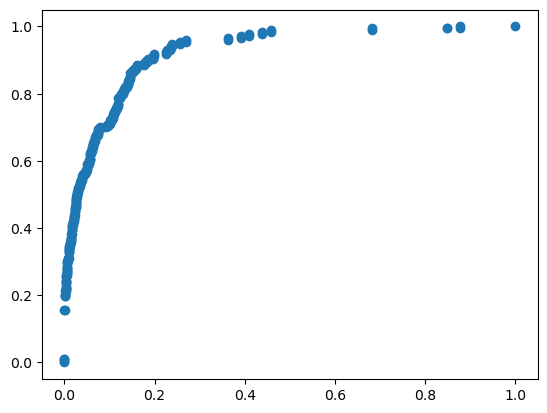

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.84s/it]

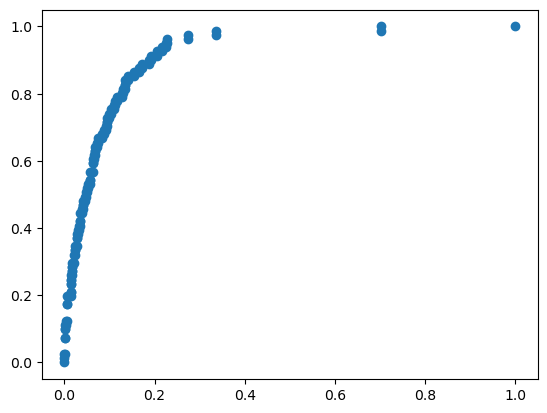

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

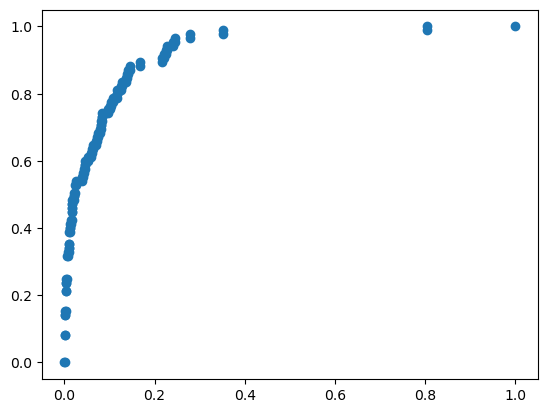

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Epoch: 8 of 30, 0.065 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

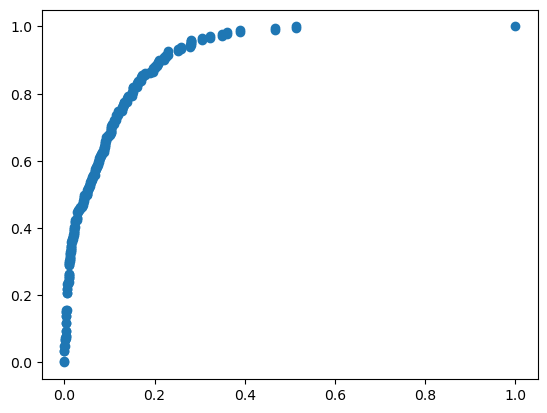

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.53s/it]

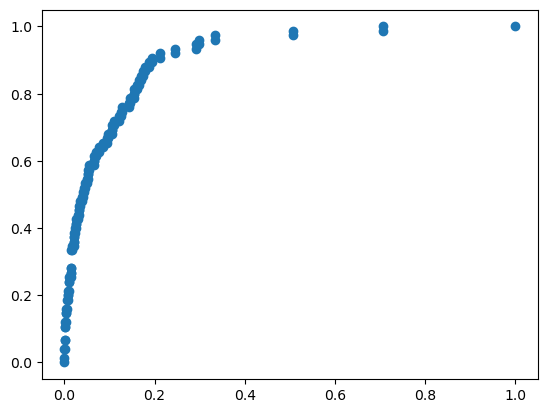

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

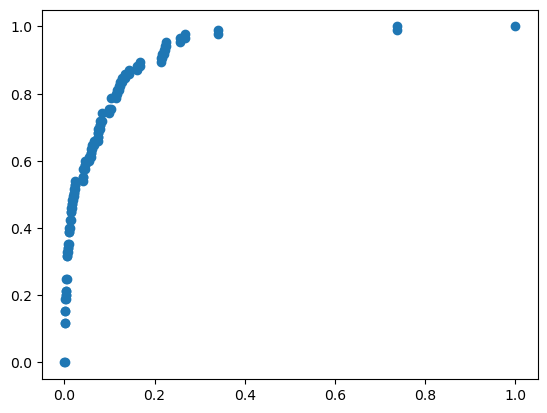

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Epoch: 9 of 30, 0.061 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

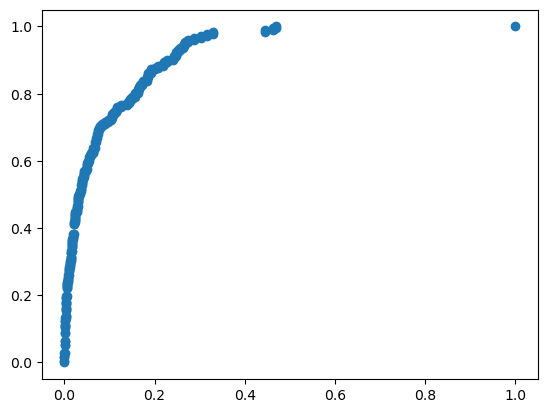

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:02<00:02,  2.13s/it]

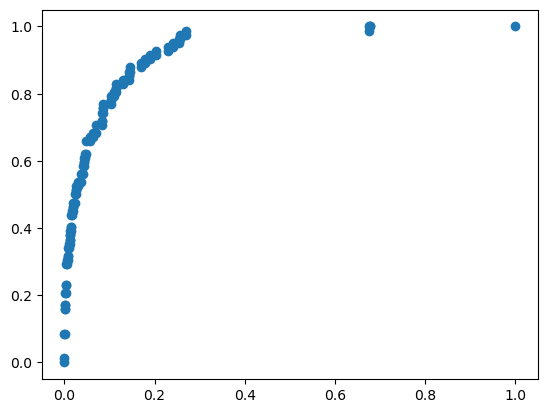

Let's see how good I am...:   0%|          | 0/1 [00:00<?, ?it/s]

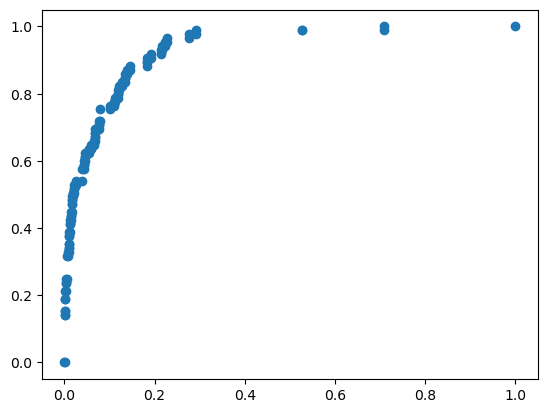

Let's see how good I am...: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Epoch: 10 of 30, 0.072 min


I'm studying hard now🧐, don't disturb!:   0%|          | 0/2 [00:00<?, ?it/s]

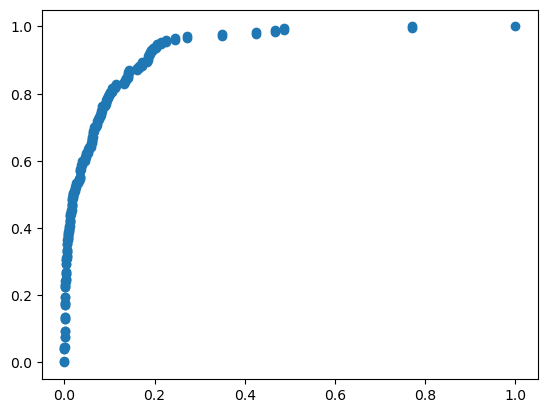

I'm studying hard now🧐, don't disturb!:  50%|█████     | 1/2 [00:01<00:01,  1.78s/it]


KeyboardInterrupt: 

wandb: Network error (ConnectionError), entering retry loop.


In [31]:
trainer.train_model(learning_params)
wandb.finish()